## Import

In [1]:
import numpy as np
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, load_trajectory, prepare_training_dataset
from stateinterpreter.utils.plot import plot_states
#Paranoia
#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
plt.set_cmap('fessa')

<Figure size 432x288 with 0 Axes>

## Load data

In [2]:
kBT = 2.5
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'deeptica/v2-lag100-nodes1024-256-64-3/COLVAR.csv'
traj_dict = {
        'trajectory' : BPTI_data_path+'trajectory.trr',
        'topology' : BPTI_data_path+'topology.pdb'
    }
#Load Descriptors
#desc_path = '../../../data/md_datasets/BPTI-unbiased/descritpors.pkl'
#descriptors = pd.read_pickle(desc_path)

start,stop,stride=0,None,1
colvar = load_dataframe(colvar_file, start, stop, stride) #.drop(['idx', 'time'], axis=1)

colvar.head()

,DeepTICA 1,DeepTICA 2,DeepTICA 3
0,0.818829,0.936690,0.391020
1,0.826180,1.034729,0.398371
2,0.837799,1.079363,0.427052
3,0.822358,0.859656,0.411466
4,0.819523,0.936758,0.413024


In [3]:
from stateinterpreter.descriptors import compute_descriptors

traj = load_trajectory(traj_dict,start,stop,stride)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['dihedrals',  'disulfide', 'hbonds_distances', 'hbonds_contacts'] )

['DISULFIDE dih CYS5_CYS55', 'DISULFIDE sin_dih CYS5_CYS55', 'DISULFIDE cos_dih CYS5_CYS55', 'DISULFIDE dih CYS14_CYS38', 'DISULFIDE sin_dih CYS14_CYS38', 'DISULFIDE cos_dih CYS14_CYS38', 'DISULFIDE dih CYS30_CYS51', 'DISULFIDE sin_dih CYS30_CYS51', 'DISULFIDE cos_dih CYS30_CYS51']
{'DISULFIDE dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE sin_dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE cos_dih CYS5_CYS55': {'atoms': [76, 77, 862, 861], 'group': 'CYS5_CYS55'}, 'DISULFIDE dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE sin_dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE cos_dih CYS14_CYS38': {'atoms': [204, 205, 589, 588], 'group': 'CYS14_CYS38'}, 'DISULFIDE dih CYS30_CYS51': {'atoms': [476, 477, 797, 796], 'group': 'CYS30_CYS51'}, 'DISULFIDE sin_dih CYS30_CYS51': {'atoms': [476, 477, 797, 796], 'group': 'CYS30_CYS51'}, 'DISULFIDE cos_dih C

# miscellanea

In [34]:
# Select only contacts which are greater than 0.5 at least once during the simulation
selected = ((descriptors.filter(regex='HB_CONTACT')>0.5).sum()>0)
desc = descriptors[selected.index[selected]]
desc.shape

(20625, 798)

Identify states

In [ ]:
cv_list = ['DeepTICA 1', 'DeepTICA 2', 'DeepTICA 3']
kBT = 2.5
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.15, fes_cutoff=kBT)

plot_states(colvar, states_labels, cv_list, fes_isolines=True, **{'bw_method':0.15}, cmap_name='fessa')

### PLOT Fes and Rmsd

In [ ]:
fig, ax_fake = plt.subplots(1)

In [ ]:
import mdtraj as md
from stateinterpreter.io import load_trajectory

# Compute RMSD
traj = load_trajectory(traj_dict,stride=stride)
traj_file = traj_dict["trajectory"]
topo_file = traj_dict["topology"] if "topology" in traj_dict else None

traj = md.load(traj_file, top=topo_file, stride=stride)

file_ref = BPTI_data_path+'RMSD-reference.pdb'
rmsd_ref = md.load(topo_file)

df, _ = traj.top.to_dataframe()
# CA RMSD
rmsd = md.rmsd(traj,rmsd_ref,atom_indices=df [df['name'] == 'CA'].index)
# HEAVY ATOMS RMSD
#rmsd = md.rmsd(traj,rmsd_ref,atom_indices=df [df['element'] != 'H'].index)

In [ ]:
from itertools import combinations

def plot_states_v2(colvar, state_labels, selected_cvs, fes_isolines = False, n_iso_fes = 9, ev_iso_labels = 2, alpha=0.3, cmap_name = 'Set2', save_folder=None, axs = None, **kde_kwargs):
    states = state_labels['labels'].unique()
    n_states = len(states)

    # hexbin plot of tica components 
    idxs_pairs = [p for p in combinations(np.arange(len(selected_cvs)), 2)]
    n_pairs = len(idxs_pairs)

    if axs is None:
        fig, axs = plt.subplots(1,n_pairs,figsize=(4.8*n_pairs,4), dpi=100)

    for k, (x_idx,y_idx) in enumerate(idxs_pairs):
        
        label_x = selected_cvs[x_idx]
        label_y = selected_cvs[y_idx]
        # select ax
        ax = axs[k] if n_pairs > 1 else axs

        # FES isolines (if 2D)
        if fes_isolines:
            #logweights = None
            #bw_method = 0.15

            num_samples = 100

            cmap = matplotlib.cm.get_cmap('Greys_r', n_iso_fes)
            color_list = [cmap((i+1)/(n_iso_fes+3)) for i in range(n_iso_fes)]

            empirical_centers = colvar[[label_x,label_y]].to_numpy()
            KDE = gaussian_kde(empirical_centers,**kde_kwargs)

            #bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
            bounds = []
            for x in KDE.dataset.T:
                bound = [x.min(), x.max()]
                if bound[0] > -1:
                    bound[0] = -1
                if bound[1] < 1:
                    bound[1] = 1
                bounds.append(bound)

            mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

            positions = np.vstack([g.ravel() for g in mesh]).T
            fes = -KDE.logpdf(positions).reshape(num_samples,num_samples)
            fes -= fes.min()

            CS = ax.contour(*mesh, fes, levels=np.linspace(0,n_iso_fes-1,n_iso_fes), colors = color_list)
        if ev_iso_labels > 0:
            ax.clabel(CS, CS.levels[::ev_iso_labels], fmt = lambda x: str(int(x))+ r'$k_{{\rm B}}T$', inline=True, fontsize=8)

        # Hexbin plot
        x = colvar[label_x]
        y = colvar[label_y]
        z = state_labels['labels']
        sel = state_labels['selection']
        not_sel = np.logical_not(sel)

        cmap = matplotlib.cm.get_cmap(cmap_name, n_states)
        color_list = [cmap(i/(n_states)) for i in range(n_states)] 
      
        ax.hexbin(x[not_sel],y[not_sel],C=z[not_sel],cmap=cmap_name,alpha=alpha)
        ax.hexbin(x[sel],y[sel],C=z[sel],cmap=cmap_name)
     
        if axs is None:
            ax.set_title('Metastable states identification')
        ax.set_xlabel(label_x)
        ax.set_ylabel(label_y)
    
        #Add basins labels
        for b in states:
            mask = np.logical_and(sel, z == b)
            #If weighted not ok but functional
            mx,my = np.mean(x[mask]), np.mean(y[mask])
            ax.scatter(mx,my,color=color_list[b],s=300,alpha=1)
            _ = ax.text(mx, my, b, ha="center", va="center", color='w', fontsize='large')

    if save_folder is not None:
        plt.savefig(save_folder+'states.pdf',bbox_inches='tight')
    
    if axs is None:
        plt.tight_layout()
        return fig, axs

In [ ]:
centimeters = 1/2.54

fig, axes = plt.subplots(1,3,figsize=(18*centimeters,6*centimeters), dpi=300, constrained_layout=True)
axs = [axes[0],ax_fake,axes[1]]

#plt.suptitle('Metastable states identification')

# PLT FES aND LABELS
plot_states_v2(colvar, states_labels, cv_list, fes_isolines=True, **{'bw_method':0.15}, alpha=0, cmap_name = 'fessa', n_iso_fes=10, ev_iso_labels=0, axs= axs)

for ax in [axs[0],axs[2]]:
    #ax.set_xlim(-1.1,1.1)
    #ax.set_ylim(-1.1,1.1)
    ax.set_xticks([-1,1])
    ax.set_yticks([-1,1])

#fix labels
ax=axs[0]
ax.set_xlabel('DeepTICA 1',labelpad=-5)
ax.set_ylabel('DeepTICA 2',labelpad=-10)

ax=axs[2]
ax.set_xlabel('DeepTICA 2',labelpad=-5)
ax.set_ylabel('DeepTICA 3',labelpad=-10)

# PLT RMSD
ax=axes[2]

# running average
N=5
ave = np.convolve(rmsd, np.ones(N)/N, mode='same')

pp = ax.scatter(np.arange(len(ave[5::5]))*0.05,ave[5::5],c=states_labels['labels'].values[5::5],s=0.1)
ax.set_xlabel(r'Time [$\mu s$]',labelpad=-5)
ax.set_ylabel(r'$C_\alpha$ RMSD [nm]')
ax.set_xticks([0,1000])

#cbar = plt.colorbar(pp,ax=ax)
#cbar.set_label('State')

save_folder = 'bpti-figs/'
plt.savefig(save_folder+'states.pdf',bbox_inches='tight')

In [ ]:
import mdtraj as md
from stateinterpreter.io import load_trajectory

ax=axs[3]

traj = load_trajectory(traj_dict,stride=stride)
traj_file = traj_dict["trajectory"]
topo_file = traj_dict["topology"] if "topology" in traj_dict else None

traj = md.load(traj_file, top=topo_file, stride=stride)

file_ref = BPTI_data_path+'RMSD-reference.pdb'
rmsd_ref = md.load(topo_file)

df, _ = traj.top.to_dataframe()
# CA RMSD
rmsd = md.rmsd(traj,rmsd_ref,atom_indices=df [df['name'] == 'CA'].index)
# HEAVY ATOMS RMSD
#rmsd = md.rmsd(traj,rmsd_ref,atom_indices=df [df['element'] != 'H'].index)

ax.scatter(np.arange(len(rmsd)),rmsd,c=states_labels['labels'].values,s=0.25)

## Group lasso on dihedral angles

Number of groups vs. regularization strength $\lambda$

NOI --> DES
0 : 'DES-3'
1 : 'DES-0'
2 : 'DES-4'
3 : 'DES-2b'
4 : 'DES-2a'
5 : 'DES-1'

Optimizing Lasso Estimator: 100%|██████████| 25/25 [22:27<00:00, 53.89s/it]


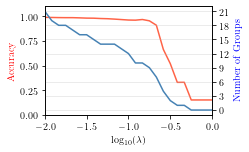

In [26]:
state_names = None #['DES-3','DES-0','DES-4','DES-2b','DES-2a','DES-1']
states_subset = [0,1,2,3,4,5]

regularizers = np.geomspace(0.01, 1, 25)
#regularizers = 10**(-0.5)
select_feat = 'sin_|cos_'
sample_obj, features_names, classes_names = prepare_training_dataset(descriptors, states_labels, 1000, regex_filter=select_feat, 
                                                    states_subset=states_subset, states_names=state_names)
groups = [feats_info[name]['group'] for name in features_names]
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, groups=groups)

classifier.plot();

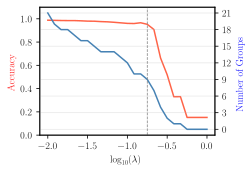

In [41]:
reg = 10**(-0.75)

# plot setup
centimeters = 1/2.54
fig, ax = plt.subplots(dpi=300,figsize=(8*centimeters,6*centimeters))

from stateinterpreter.plot import plot_classifier_complexity_vs_accuracy
ax1,ax2 = plot_classifier_complexity_vs_accuracy(classifier,ax=ax)
ax2.axvline(x = np.log10(reg), color='grey', linestyle='dashed', linewidth=0.75)

save_folder = 'bpti-figs/'
plt.savefig(save_folder+'group_accuracy.pdf',bbox_inches='tight')
plt.show()

In [35]:
reg = 10**(-0.75)
classifier.print_selected(reg)

Accuracy: 95%
State 0:
[100.0% ]  ARG42
State 1:
[100.0% ]  CYS38
State 2:
[95.498%]  PHE4
[4.502% ]  PRO2
State 3:
[78.38% ]  THR11
[21.62% ]  CYS38
State 4:
[96.534%]  TYR35
[3.466% ]  PRO9
State 5:
[87.389%]  CYS38
[8.943% ]  PRO13
[3.668% ]  TYR10


Residue importances

In [46]:
from stateinterpreter.utils.visualize import compute_residue_score 

traj = load_trajectory(traj_dict, stride=stride)
# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

In [48]:
descriptors.filter(regex='sin_|cos_')

,BACKBONE sin_phi ARG1,BACKBONE sin_phi PRO2,BACKBONE sin_phi ASP3,BACKBONE sin_phi PHE4,BACKBONE sin_phi CYS5,BACKBONE sin_phi LEU6,BACKBONE sin_phi GLU7,BACKBONE sin_phi PRO8,BACKBONE sin_phi PRO9,BACKBONE sin_phi TYR10,...,SIDECHAIN cos_chi2 GLU49,SIDECHAIN cos_chi2 ASP50,SIDECHAIN cos_chi2 MET52,SIDECHAIN cos_chi2 ARG53,DISULFIDE sin_dih CYS5_CYS55,DISULFIDE cos_dih CYS5_CYS55,DISULFIDE sin_dih CYS14_CYS38,DISULFIDE cos_dih CYS14_CYS38,DISULFIDE sin_dih CYS30_CYS51,DISULFIDE cos_dih CYS30_CYS51
0,-0.800495,-0.926716,-0.975521,-0.999744,-0.999964,-0.962204,-0.874549,-0.950574,-0.370935,-0.873390,...,-0.998442,0.500169,-0.999495,-0.991146,-0.999536,-0.030467,0.999589,-0.028675,-0.975816,-0.218593
1,-0.933559,-0.730527,-0.979260,-0.934574,-0.998159,-0.959778,-0.868239,-0.934651,-0.689149,-0.996072,...,-0.999974,-0.438326,-0.353263,-0.961761,-0.999017,-0.044320,0.999120,-0.041941,-0.980741,-0.195314
2,-0.970335,-0.969054,-0.864596,-0.835896,-0.992462,-0.982925,-0.855188,-0.938998,-0.668086,-0.984464,...,0.352362,0.957875,0.453912,-0.994874,-0.993370,0.114965,0.997402,-0.072043,-0.995064,0.099239
3,-0.847304,-0.831210,-0.981629,-0.962950,-0.982618,-0.973111,-0.924221,-0.995836,-0.806495,-0.907892,...,-0.934253,0.700958,0.648715,-0.996773,-0.995607,0.093635,0.977207,-0.212290,-0.999664,-0.025920
4,-0.975500,-0.906739,-0.990261,-0.894916,-0.197879,-0.805221,-0.931033,-0.918382,-0.957573,-0.956490,...,-0.995252,-0.283845,0.338350,-0.999601,-0.971392,0.237480,0.994021,-0.109190,-0.982214,0.187764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103120,-0.966238,-0.697278,-0.875134,-0.935926,-0.993331,-0.903049,-0.966906,-0.967213,-0.990404,-0.433217,...,-0.994578,0.022313,0.368546,-0.988016,-0.994428,0.105422,0.994405,0.105631,-0.995214,0.097723
103121,-0.857157,-0.803395,-0.930556,-0.910705,-0.999797,-0.670322,-0.922231,-0.862807,-0.516614,-0.735013,...,-0.987542,-0.506539,0.324005,-0.954476,-0.983773,0.179417,0.998822,-0.048520,-0.999442,0.033401
103122,-0.934079,-0.966747,-0.980075,-0.878948,-0.977967,-0.961989,-0.718325,-0.998058,-0.846795,-0.979347,...,-0.999763,0.444429,0.414626,-0.997842,-0.968065,0.250701,0.999915,-0.013017,-0.968832,-0.247718
103123,-0.881133,-0.852202,-0.971750,-0.966360,-0.988626,-0.781133,-0.955955,-0.949794,-0.682090,-0.999667,...,-0.935948,0.589731,-0.998718,-0.991697,-0.999991,0.004172,0.992962,-0.118431,-0.994371,0.105958


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get residue names
table, _ = traj.topology.to_dataframe()
residue_names = table["resName"] + table["resSeq"].astype("str")
residue_names = residue_names.unique()

# transform dictionary of residue scores into matrix and then into df to plot with seaborn (switch back to matplotlib?)
score_matrix = np.row_stack([score for score in residue_score.values()])
score_df = pd.DataFrame(score_matrix, columns = residue_names, index=[v for v in classes_names.values()])

# Plot
centimeters = 1
plt.figure(figsize=(len(residue_names)*0.5*centimeters,6*centimeters))
sns.heatmap(score_df, annot=True, fmt=".2f", cmap='Reds', linewidths=2)

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Residue score')
plt.show()

In [ ]:
from stateinterpreter.visualize import visualize_residue_score

visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='cartoon')

In [ ]:
reg = 10**(-1.5)
classifier.plot_regularization_path(reg);
classifier.print_selected(reg)

### Lasso on group selection

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:01<00:00, 14.90it/s]


(<Figure size 216x144 with 2 Axes>,
 (<AxesSubplot:xlabel='$\\log_{10}(\\lambda)$', ylabel='Accuracy'>,
  <AxesSubplot:ylabel='Number of Features'>))

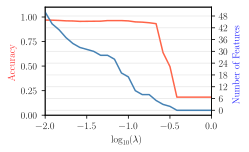

In [38]:
regularizers = np.geomspace(0.01, 1, 25)
#sample_obj, features_names, classes_names = sample(descriptors, states_labels, 1000, states_subset=[0,1], states_names=["Low", 'Hi'])
pruned_classifier = classifier.prune(reg)
pruned_classifier.compute(regularizers, max_iter= 10000)

pruned_classifier.plot()

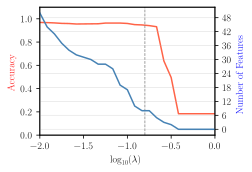

Accuracy: 94%
State 0:
[100.0% ]  BACKBONE sin_phi ARG42
State 1:
[100.0% ]  BACKBONE sin_psi CYS38
State 2:
[100.0% ]  BACKBONE sin_phi PRO2
State 3:
[97.575%]  BACKBONE sin_phi THR11
[2.425% ]  BACKBONE sin_phi CYS38
State 4:
[96.507%]  BACKBONE sin_phi TYR35
[3.493% ]  BACKBONE cos_psi PRO9
State 5:
[79.503%]  BACKBONE sin_phi CYS38
[20.497%]  BACKBONE cos_phi TYR10


In [45]:
log_reg = -0.8
reg = 10**(log_reg)

# plot setup
centimeters = 1/2.54
fig, ax = plt.subplots(dpi=300,figsize=(8*centimeters,6*centimeters))

from stateinterpreter.plot import plot_classifier_complexity_vs_accuracy
plot_classifier_complexity_vs_accuracy(pruned_classifier,ax=ax)
ax.axvline(x = log_reg, color='grey', linestyle='dashed', linewidth=0.75)

save_folder = 'bpti-figs/'
plt.savefig(save_folder+'pruned_accuracy.pdf',bbox_inches='tight')

plt.show()

pruned_classifier.print_selected(reg)

In [ ]:
from stateinterpreter.plot import plot_histogram_features

relevant_feat = pruned_classifier.feature_summary(reg)
plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

In [ ]:
mask = ( states_labels['selection'] == 1 ) # & ( states_labels['labels'] != 0)
xx = descriptors[mask]['BACKBONE phi ARG42'].values
c = states_labels[mask]['labels'].values
t = traj.time[mask]

N=1
#ave = np.convolve(xx, np.ones(N)/N, mode='same')[N::N]
#t = np.arange(len(ave))*0.01*N

# plot setup
centimeters = 1/2.54
fig, ax = plt.subplots(dpi=300,figsize=(8*centimeters,6*centimeters))

# get discrete colormap
cmap = plt.get_cmap('fessa', np.max(c)-np.min(c)+1)

pp = ax.scatter(t,xx,c=c,s=0.1, cmap= cmap, vmin = np.min(c)-.5, vmax = np.max(c)+.5)

plt.colorbar(pp,ax=ax)

ax.set_xlabel(r'Time [$\mu$s]')
ax.set_ylabel(r'$\phi$(ARG42)')

plt.savefig(save_folder+'arg42.pdf',bbox_inches='tight')

In [ ]:
from stateinterpreter.numerical_utils import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt

# COMPUTE FES
selected_cvs = ['BACKBONE phi CYS38', 'BACKBONE psi CYS38']
logweights = None
bw_method = 0.15

num_samples = 200
n_iso_fes = 10
ev_iso_labels = 2

cmap = matplotlib.cm.get_cmap('Greys_r', n_iso_fes)
color_list = [cmap((i+1)/(n_iso_fes+3)) for i in range(n_iso_fes)]

empirical_centers = descriptors[selected_cvs].to_numpy()
KDE = gaussian_kde(empirical_centers,bw_method=bw_method,logweights=logweights)

#bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
bounds = [(-np.pi,np.pi),(-np.pi,np.pi)]
mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

positions = np.vstack([g.ravel() for g in mesh]).T
fes = -KDE.logpdf(positions).reshape(num_samples,num_samples)
fes -= fes.min()

# PLOT ISOLINES
centimeters = 1/2.54
fig, ax = plt.subplots(dpi=300,figsize=(8*centimeters,6*centimeters))
CS = ax.contour(*mesh, fes, levels=np.linspace(0,n_iso_fes-1,n_iso_fes), colors = color_list)
ax.clabel(CS, CS.levels[::ev_iso_labels], fmt = lambda x: str(int(x))+ r'$k_{{\rm B}}T$', inline=True, fontsize=6)

# SCATTER
mask = ( states_labels['selection'] == 1 )
xx = descriptors[mask]['BACKBONE phi CYS38']
yy = descriptors[mask]['BACKBONE psi CYS38']
c = states_labels[mask]['labels']

cmap = plt.get_cmap('fessa', np.max(c)-np.min(c)+1)
#pp = ax.hexbin(xx,yy,C=c,cmap= cmap, vmin = np.min(c)-.5, vmax = np.max(c)+.5)
pp = ax.scatter(xx,yy,c=c,s=0.1, cmap= cmap, vmin = np.min(c)-.5, vmax = np.max(c)+.5)
cbar = plt.colorbar(pp,ax=ax)
cbar.set_label('State')

# SETUP 
ax.set_xlabel(r'$\phi$(CYS38)',labelpad=-5)
ax.set_ylabel(r'$\psi$(CYS38)',labelpad=-10)
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.set_xticks([-np.pi/2,np.pi/2])
ax.set_yticks([-np.pi/2,np.pi/2])
ax.set_xticklabels ([r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'])
ax.set_yticklabels ([r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'])
ax.axis('equal')
plt.tight_layout()

plt.savefig(save_folder+'ramachandran_cys38.pdf',bbox_inches='tight')

In [ ]:
from stateinterpreter.numerical_utils import gaussian_kde
import matplotlib
import matplotlib.pyplot as plt

residues = ['CYS38','ARG42','TYR35','PRO2' ]

centimeters = 1/2.54
fig, axs = plt.subplots(2,2,dpi=300,figsize=(18*centimeters,16*centimeters),constrained_layout=True)

axs_flat = axs.flat

for i,residue in enumerate(residues):
    # COMPUTE FES
    selected_cvs = ['BACKBONE phi '+residue, 'BACKBONE psi '+residue]
    logweights = None
    bw_method = 0.15

    num_samples = 200
    n_iso_fes = 10
    ev_iso_labels = 2

    cmap = matplotlib.cm.get_cmap('Greys_r', n_iso_fes)
    color_list = [cmap((i+1)/(n_iso_fes+3)) for i in range(n_iso_fes)]

    empirical_centers = descriptors[selected_cvs].to_numpy()
    KDE = gaussian_kde(empirical_centers,bw_method=bw_method,logweights=logweights)

    #bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
    bounds = [(-np.pi,np.pi),(-np.pi,np.pi)]
    mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

    positions = np.vstack([g.ravel() for g in mesh]).T
    fes = -KDE.logpdf(positions).reshape(num_samples,num_samples)
    fes -= fes.min()

    # PLOT ISOLINES
    ax = axs.flat[i]
    CS = ax.contour(*mesh, fes, levels=np.linspace(0,n_iso_fes-1,n_iso_fes), colors = color_list)
    #ax.clabel(CS, CS.levels[::ev_iso_labels], fmt = lambda x: str(int(x))+ r'$k_{{\rm B}}T$', inline=True, fontsize=6)

    # SCATTER
    mask = ( states_labels['selection'] == 1 )
    xx = descriptors[mask][selected_cvs[0]]
    yy = descriptors[mask][selected_cvs[1]]
    c = states_labels[mask]['labels']

    cmap = plt.get_cmap('fessa', np.max(c)-np.min(c)+1)
    #pp = ax.hexbin(xx,yy,C=c,cmap= cmap, vmin = np.min(c)-.5, vmax = np.max(c)+.5)
    pp = ax.scatter(xx,yy,c=c,s=0.1, cmap= cmap, vmin = np.min(c)-.5, vmax = np.max(c)+.5)
    cbar = plt.colorbar(pp,ax=ax)
    cbar.set_label('State')

    # SETUP 
    ax.set_xlabel(r'$\phi$({})'.format(residue),labelpad=-5)
    ax.set_ylabel(r'$\psi$({})'.format(residue),labelpad=-10)
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
    #ax.set_xticklabels ([r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'])
    #ax.set_yticklabels ([r'$-\frac{\pi}{2}$',r'$\frac{\pi}{2}$'])
    ax.set_xticklabels ([r'$-\pi$','','','',r'$\pi$'])
    ax.set_yticklabels ([r'$-\pi$','','','',r'$\pi$'])
    ax.set_aspect('equal', 'box')

#plt.tight_layout()

plt.savefig(save_folder+'ramachandran_multi.pdf',bbox_inches='tight')

In [ ]:
reg = 10**(-0.8)
pruned_classifier.print_selected(reg)
pruned_classifier.plot_regularization_path(reg); 

In [ ]:
from stateinterpreter.io import load_trajectory
from stateinterpreter.visualize import compute_residue_score 

# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(pruned_classifier,reg,feats_info,n_residues)

In [ ]:
from stateinterpreter.visualize import visualize_residue_score

visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='cartoon')

In [ ]:
from stateinterpreter.visualize import visualize_features

relevant_feat = classifier.feature_summary(reg)
visualize_features(traj, states_labels, classes_names, relevant_feat, feats_info, state = 0, representation = 'cartoon')

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get residue names
table, _ = traj.topology.to_dataframe()
residue_names = table["resName"] + table["resSeq"].astype("str")
residue_names = residue_names.unique()

# transform dictionary of residue scores into matrix and then into df to plot with seaborn (switch back to matplotlib?)
score_matrix = np.row_stack([score for score in residue_score.values()])
score_df = pd.DataFrame(score_matrix, columns = residue_names, index=[v for v in classes_names.values()])

# Plot
plt.figure(figsize=(len(residue_names)*0.5,6))
sns.heatmap(score_df, annot=True, fmt=".2f", cmap='Reds', linewidths=2)

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Residue score')
plt.show()

# Standard lasso

## HBONDS

In [ ]:
regularizers = np.geomspace(0.1, 1, 11)
select_feat = 'HB_CONT'
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 1000, regex_filter=select_feat, 
                                                    states_subset=states_subset, states_names=state_names)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

classifier.plot();

In [ ]:
reg = 10**(-0.75)
classifier.print_selected(reg)

In [ ]:
from stateinterpreter.plot import plot_combination_states_features
import matplotlib.pyplot as plt 

relevant_feat = classifier.feature_summary(reg)
plot_combination_states_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)
plt.tight_layout()

In [ ]:
from stateinterpreter.plot import plot_histogram_features

plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

In [ ]:
from stateinterpreter.visualize import visualize_features
from stateinterpreter.io import load_trajectory

traj = load_trajectory(traj_dict,stride=stride)
visualize_features(traj, states_labels, classes_names, relevant_feat, feats_info, state = 4, representation = 'licorice')

### Quadratic kernel

In [ ]:
pruned_classifier = classifier.prune(reg)
pruned_classifier.compute(regularizers, quadratic_kernel=True, max_iter= 10000)

pruned_classifier.plot()

In [ ]:
reg = 10**(-0.5)
pruned_classifier.print_selected(reg)

In [ ]:
relevant_feat = classifier.feature_summary(reg)
plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

## Dihedrals

In [ ]:
state_names = ['DES-3','DES-0','DES-4','DES-2b','DES-2a','DES-1']
states_subset = [0,2,3,4,5,6]

In [ ]:
regularizers = np.geomspace(0.01, 1, 11)
select_feat = 'sin_|cos_'
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 1000, regex_filter=select_feat, 
                                                    states_subset=states_subset, states_names=state_names)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

classifier.plot();

In [ ]:
reg = 10**(-1)
classifier.print_selected(reg)

In [ ]:
from stateinterpreter.plot import plot_combination_states_features
import matplotlib.pyplot as plt 

relevant_feat = classifier.feature_summary(reg)
plot_combination_states_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)
#plt.tight_layout()

In [ ]:
from stateinterpreter.plot import plot_histogram_features

plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

In [ ]:
from stateinterpreter.io import load_trajectory
from stateinterpreter.visualize import compute_residue_score 

traj = load_trajectory(traj_dict, stride=stride)
# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# get residue names
table, _ = traj.topology.to_dataframe()
residue_names = table["resName"] + table["resSeq"].astype("str")
residue_names = residue_names.unique()

# transform dictionary of residue scores into matrix and then into df to plot with seaborn (switch back to matplotlib?)
score_matrix = np.row_stack([score for score in residue_score.values()])
score_df = pd.DataFrame(score_matrix, columns = residue_names, index=[v for v in classes_names.values()])

# Plot
plt.figure(figsize=(len(residue_names)*0.5,6))
sns.heatmap(score_df, annot=True, fmt=".2f", cmap='Reds', linewidths=2)

plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.title('Residue score')
plt.show()

Quadratic Kernel

In [ ]:
regularizers = np.geomspace(0.01, 1, 25)
pruned_classifier = classifier.prune(reg,)
pruned_classifier.compute(regularizers, quadratic_kernel=True, max_iter= 10000)

pruned_classifier.plot()

In [ ]:
reg = 10**(-0.5)
pruned_classifier.print_selected(reg)

In [ ]:
from stateinterpreter.plot import plot_combination_states_features
import matplotlib.pyplot as plt 

relevant_feat = pruned_classifier.feature_summary(reg)
plot_combination_states_features(colvar,descriptors,cv_list,relevant_feat,state_labels=states_labels)

In [ ]:
from stateinterpreter.plot import plot_histogram_features

plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

# SASA on 0 vs rest

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 2094 configurations.
	Basin 1 -> 96718 configurations.


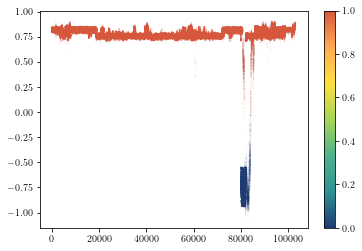

In [36]:
cv_list = ['DeepTICA 1']
kBT = 2.5
states_labels = identify_metastable_states(colvar, cv_list, kBT, bw_method=0.15, fes_cutoff=kBT)

mask = states_labels['selection'] == 1
plt.scatter(np.arange(len(colvar)), colvar[cv_list], c = states_labels['labels'], s = 0.1,alpha=0.1)
pp = plt.scatter(np.arange(len(colvar[mask])), colvar[mask][cv_list], c = states_labels[mask]['labels'], s = 0.1,alpha=1)
plt.colorbar()
#plot_states(colvar, states_labels, cv_list, fes_isolines=True, **{'bw_method':0.15}, cmap_name='fessa')

In [38]:
states_labels[states_labels['labels'] == 0].sample(1)

,labels,selection
82957,0,True


In [10]:
#calculate descriptors
import mdtraj as md
# SASA

mode = 'residue'

traj = md.load(traj_dict['trajectory'], top=traj_dict['topology'], stride=stride)#, atom_indices = traj.top.select('protein'))
sasa = md.shrake_rupley(traj,mode=mode)

print(sasa.shape)

import pandas as pd

names = []
feats_info = {}

table, bonds = traj.top.to_dataframe()

if mode == 'atom':
    for idx in range(traj.n_atoms):
        name = 'SASA '+str(traj.top.atom(idx))
        names.append(name)
        feats_info[name] = {
            'atoms': [idx],
            'group': table["resName"][idx] + table["resSeq"][idx].astype("str")
        }
elif mode == 'residue':
    for res in traj.top.residues:
        name = 'SASA '+str(res)
        names.append(name)
        feats_info[name] = {
            #'atoms': [idx],
            'group': str(res)
        }
descriptors = pd.DataFrame(sasa, columns=names) 

descriptors

(103125, 58)


,SASA ARG1,SASA PRO2,SASA ASP3,SASA PHE4,SASA CYS5,SASA LEU6,SASA GLU7,SASA PRO8,SASA PRO9,SASA TYR10,...,SASA GLU49,SASA ASP50,SASA CYS51,SASA MET52,SASA ARG53,SASA THR54,SASA CYS55,SASA GLY56,SASA GLY57,SASA ALA58
0,1.099962,0.524975,0.995111,0.769809,0.000000e+00,1.154583,0.335177,1.100501,0.500973,0.852805,...,1.249677,0.275696,0.0,1.181362,1.798351,0.535614,0.000000e+00,0.521890,0.460957,1.328122
1,1.141736,0.647664,1.063257,0.726136,8.848819e-04,1.352720,0.361452,0.733724,0.420077,1.019489,...,1.222329,0.436374,0.0,1.402522,1.870236,0.455180,2.260575e-02,0.373593,0.800718,1.374059
2,1.552173,0.580780,1.234221,0.722276,7.830159e-07,0.787330,0.323951,0.744376,0.511902,1.172669,...,1.131043,0.143955,0.0,1.110286,1.934112,0.452785,2.168415e-03,0.131982,0.489193,1.641537
3,1.678078,0.559984,1.335652,0.508590,6.928766e-10,1.138489,0.607993,1.083300,0.346442,1.164071,...,1.144953,0.322470,0.0,0.660122,2.095870,0.519053,2.394451e-06,0.263163,0.554062,1.796579
4,1.507681,0.505891,1.100117,0.313368,3.871238e-02,1.422832,0.564999,1.001045,0.451675,0.987744,...,1.459088,0.527855,0.0,0.877392,2.241290,0.520313,2.716426e-09,0.218849,0.583376,1.433574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103120,0.988555,0.532069,1.293645,0.690284,1.153597e-03,0.997396,0.868174,0.628643,0.043528,1.462217,...,1.104613,0.553409,0.0,0.871810,1.973288,0.569353,5.576282e-09,0.373503,0.599514,1.496040
103121,1.314960,0.472399,1.233714,0.272588,3.349593e-03,1.101382,0.967791,0.530495,0.003588,1.442700,...,1.411432,0.367121,0.0,0.784554,1.682969,0.459669,6.225837e-12,0.464457,0.399868,1.276764
103122,1.429128,0.510590,1.336736,0.399423,3.738488e-06,1.135008,0.696672,0.848874,0.099726,0.914115,...,1.239789,0.450235,0.0,1.117825,1.840205,0.456592,6.951357e-15,0.344495,0.316335,1.336097
103123,1.734680,0.541445,1.385939,0.558892,1.785765e-02,1.225461,0.914057,0.474256,0.032562,0.810536,...,1.033351,0.350956,0.0,1.103749,1.818960,0.525961,3.053586e-02,0.384847,0.641501,1.888945


Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:00<00:00, 396.01it/s]


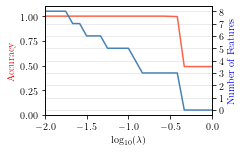

In [11]:
regularizers = np.geomspace(0.01, 1, 25)
select_feat = 'SASA'
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 1000, regex_filter=select_feat)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

classifier.plot();

In [12]:
reg = 10**(-0.8)
classifier.print_selected(reg)

Accuracy: 100%
State 0:
[42.431%]  SASA ARG39
[33.519%]  SASA LYS41
[24.05% ]  SASA PRO8
State 1:
[42.431%]  SASA ARG39
[33.519%]  SASA LYS41
[24.05% ]  SASA PRO8


NameError: name 'classifier' is not defined

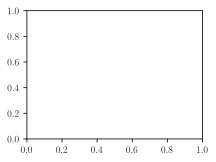

In [6]:
from stateinterpreter._configs import __useTeX__

def plot_histogram_features_single_state(descriptors,states_labels,classes_names,relevant_feat, ax, state=0, hist_offset = -0.2, n_bins = 50, ylog = False, height=0.75, width=6):

    features_per_class = [len(feat_list) for feat_list in relevant_feat.values()]

    for b, (basin, basin_name) in enumerate( classes_names.items() ):
        if basin == state:
            feat_list = relevant_feat[basin_name]

            #fig,ax = plt.subplots( figsize = (4,0.5*len(feat_list)) )
            #ax = axs[b]
            feature_labels = []
            for h, feature in enumerate( feat_list[::-1] ):
                feature_name = feature[2]
                if (__useTeX__) and ('_' in feature_name):
                    feature_label = feature_name.replace('_','\_')
                else:
                    feature_label = feature_name
                feature_label=feature_label.replace('SASA ','')
                
                feature_labels.append(feature_label)

                # formatting
                if feature_labels is None:
                    feature_labels = [str(n) for n in range(len(feat_list))]
                    ax.set_ylabel('Feature histograms')

                #coordinate = descriptors[feature_name]
                #hist, edges = np.histogram(coordinate, bins=n_bins)
                for i in classes_names.keys():
                    x_i = descriptors[ ( states_labels['labels'] == i ) & ( states_labels['selection'] ) ][feature_name]
                    hist, edges = np.histogram(x_i, bins=n_bins)
                    if not ylog:
                        y = hist / hist.max()
                    else:
                        y = np.zeros_like(hist) + np.NaN
                        pos_idx = hist > 0
                        y[pos_idx] = np.log(hist[pos_idx]) / np.log(hist[pos_idx]).max()
                    color = 'fessa0' if i == 0 else 'grey'
                    feature_labels = [ feat.replace('HB\\_CONTACT ','') for feat in feature_labels]
                    alpha=0.8 if i == state else 0.8
                    label=( 'State == 0' if i == 0 else 'States != 0' ) if h == 0 else None
                    ax.fill_between(edges[:-1], y + h + hist_offset, y2=h + hist_offset, color=color, alpha=alpha, label = label)#, label=feature_labels[h] if i == 0 else None) #, **kwargs)

                ax.axhline(y=h + hist_offset, xmin=0, xmax=1, color='k', linewidth=.2)

                print(b,h,i)
            #handles, labels = ax.get_legend_handles_labels()
            #ax.legend(handles[::-1], labels[::-1],frameon=False,ncol=1,loc=3,labelspacing=3,bbox_to_anchor=(0.05, 0.))

            ax.legend(frameon=False,ncol=1,loc='lower right',fontsize='small')

            ax.set_ylim(hist_offset, h + hist_offset + 1)
            ax.set_yticks(np.array(range(len(feature_labels))) + hist_offset + .3)
            ax.set_yticklabels(feature_labels)
            #ax.set_xlabel('Feature values')
            #ax.set_title(f'{basin}: {basin_name}')

            #ax.set_yticks([])
            #ax.set_yticklabels([])

            ax.set_xlabel(r'SASA of residues [$nm^2$]')
            ax.set_ylabel('Histogram')

            #ax2 = ax.twinx()
            #ax2.set_ylim(hist_offset, h + hist_offset + 1)
            #ax2.set_yticks(np.array(range(len(feature_labels))) + .3)
            #feature_label = feature_label.replace('HB\\_CONTACT ','')
            #ax2.set_yticklabels(feature_labels,rotation=45)

# plot setup
centimeters = 1/2.54
fig, ax = plt.subplots(1,1, dpi=300,figsize=(8*centimeters,6*centimeters))#,constrained_layout=True)

relevant_feat = classifier.feature_summary(reg)
plot_histogram_features_single_state(descriptors,states_labels,classes_names,relevant_feat,ax=ax,hist_offset=1,state=1,n_bins=30)

plt.tight_layout()

save_folder =  None#'bpti-figs/'

if save_folder is not None:
        plt.savefig(save_folder+'sasa_histogram.pdf',bbox_inches='tight')

In [24]:
from stateinterpreter.io import load_trajectory
from stateinterpreter.visualize import compute_residue_score 

#traj = load_trajectory(traj_dict, stride=stride)
# number of  residues
n_residues = traj.n_residues

residue_score = compute_residue_score(classifier,reg,feats_info,n_residues)
residue_score

In [64]:
import nglview 
import matplotlib
from time import sleep 

def visualize_residue_score(trajectory, states_labels, classes_names, residue_score, representation = 'licorice', palette = 'Reds', state_frames=None):
    # sample one frame per state
    if state_frames is None:
        frames = [states_labels [( states_labels['labels'] == i ) & ( states_labels['selection'] ) ].sample(1).index.values[0] for i in classes_names.keys() ]
    else:
        frames = state_frames
        
    traj = trajectory[frames]
    traj.superpose(traj[0])

    view = nglview.show_mdtraj(traj, default=False)

    if representation == 'licorice' :
        view.add_licorice('(not hydrogen)')
    elif representation == 'cartoon' :
        view.add_cartoon('protein')
    elif representation == 'ball_and_stick' :
        view.add_ball_and_stick('(not hydrogen)')

    view.add_ball_and_stick('042 and backbone')

    # get color palette
    cmap = matplotlib.cm.get_cmap(palette, 11)
    palette = [matplotlib.colors.rgb2hex( cmap(i) ) for i in range(cmap.N)]

    # transform score in colors
    residue_colors = {}
    for i, state in enumerate( classes_names.keys() ):
        colors = []
        for i in residue_score[ classes_names[state] ]:
            col = int (i*10)*2
            colors.append( palette[col] ) 
        residue_colors[state] = colors

    # define observer function to allow changing colors with frame
    def on_change(change):
        frame = change.new
        frame_color = residue_colors[frame]
        frame_color = [c.replace('#', '0x') for c in frame_color]
        
        view._set_color_by_residue(view,frame_color)
        #view.update_licorice()
        sleep(0.1) # wait for the color update

    # convert to int
   
    # initialize set color by residue
    def _set_color_by_residue(self, colors, component_index=0, repr_index=0):
            self._remote_call('setColorByResidue',
                            target='Widget',
                            args=[colors, component_index, repr_index])

    if not hasattr(view, '_set_color_by_residue'):
        view._set_color_by_residue = _set_color_by_residue

    # set colors from state 0 
    frame_color = residue_colors[0]
    frame_color = [c.replace('#', '0x') for c in frame_color]
        
    view._set_color_by_residue(view,frame_color)
    view.observe(on_change, names=['frame'])

    return view

In [65]:
#from stateinterpreter.visualize import visualize_residue_score

view = visualize_residue_score(traj, states_labels, classes_names, residue_score, representation='cartoon',state_frames=[82957,0])

view

NGLWidget(max_frame=1)

In [67]:
view.download_image('bpti-figs/image1.png')

# Hierarchical classification

### PLOT FES

In [4]:
__all__ = ["compute_fes"]

from sklearn.neighbors import KernelDensity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import Tensor

def compute_fes(X, temp=300, num_samples=100, bounds=None, bandwidth=0.01, kernel='gaussian', weights=None, scale_by = None, blocks = 1, plot=False, plot_max_fes=None, ax = None):
    """Compute the Free Energy Surface along the given variables.

    Parameters
    ----------
    X : array-like, list of arrays
        data
    temp : float, optional
        temperature, by default 300
    num_samples : int, optional
        number of points used along each direction, by default 100
    bounds : list of lists, optional
        limit the calculation of the FES to a region, by default equal to the range of values
    bandwidth : float, optional
        Bandwidth use for the kernels, by default 0.1. 
    kernel: string, optional
        Kernel type, by default 'gaussian'. 
    weights : array, optional
        array of samples weights, by default None
    scale_by : string, optional
        Standardize each variable by its standard deviation (`std`) or by its range of values, by default None
    blocks : int, optional
        number of blocks to be used, by default 1
    plot : bool, optional
        Plot the results (only available for 1D and 2D FES), by default False
    plot_max_fes : float, optional
        Maximum value of the FES to be plotted, by default None
    ax : matplotlib axis, optional
        Axis where to plot, default create new figure
    Returns
    -------
    fes: np.array
        free energy
    grid: np.array or list of arrays (>1D)
        grid points for plotting
    bounds: list
        bounds along each variable
    std: np.array
        (weighted) standard deviation along the blocks (only if blocks>1)

    Notes
    -----
    - This function uses sklearn.neighbors.KernelDensity function to construct the estimate of the FES (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html). You can specify all the kernels supported.

    - Note that if ``scale_by`` is not none, the bandwidth is not rescaled as well. So if using ``scale_by='range'`` a bandwidth of 0.01 corresponds to a 1/100 of the range of values assumed by the variable.

    - If blocks>1 a (weighted) block analyis is performed [1], which allows also to obtain an estimate of the uncertainty.

    [1] Invernizzi, Piaggi and Parrinello, PRX, 2020,10,4

    """
    # temperature
    kb = 0.00831441
    kbt = kb * temp

    # dataset
    if type(X) == list:
        X = np.vstack(X).T
    elif type(X) == pd.DataFrame:
        X = X.values
    elif type(X) == Tensor:
        X = X.numpy()
    
    if X.ndim == 1:
        X = X.reshape([-1,1])  

    # div
    nsamples = X.shape[0]
    dim = X.shape[1]
    
    # weights
    if weights is None:
        weights = np.ones(nsamples)
    else:
        assert weights.ndim == 1
        assert weights.shape[0] == nsamples

    # rescale
    if scale_by is not None:
        if scale_by == 'std':
            scale = X.std(axis=0)
        elif scale_by == 'range':
            scale = X.max(axis=0)-X.min(axis=0)
        elif type(scale_by) == list:
            scale = np.asarray(scale_by)
        X = np.copy(X)
        X /= scale

    # eval points
    if dim == 1:
        if bounds is None:
            bounds = (X[:,0].min(), X[:,0].max())
        grid = np.linspace(bounds[0], bounds[1], num_samples)
        positions = grid.reshape([-1,1])
    else:
        if bounds is None:
            bounds = [(X[:,i].min(), X[:,i].max()) for i in range(dim)]
        grid = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])
        positions = np.vstack([g.ravel() for g in grid]).T

    # divide in blocks
    X_b = np.array_split(X,blocks)
    w_b = np.array_split(weights,blocks)

    O_i,W_i = [], [] #values per block
    # block average
    for i in range(blocks):
        # data of each block
        X_i = X_b[i]
        w_i = w_b[i]

        # fit
        kde = KernelDensity(bandwidth=bandwidth, kernel=kernel)
        kde.fit(X_i, sample_weight=w_i)

        # logpdf --> fes
        ##positions = torch.tensor(positions, dtype=torch.float32)
        fes = - kbt * kde.score_samples(positions).reshape([num_samples for i in range(dim)])
        fes -= fes.min()

        # result for each block
        O_i.append(fes)
        W_i.append(np.sum(w_i))

    O_i = np.asarray(O_i)
    W_i = np.asarray(W_i)

    # compute avg and std 
    if blocks > 1: 
        # weighted average
        O = np.dot(O_i.T,W_i)/np.sum(W_i)
        # weighted std
        dev = O_i - O
        blocks_eff = (np.sum(W_i))**2/(np.sum(W_i**2))
        variance = blocks_eff/(blocks_eff - 1) * (np.dot((dev**2).T,W_i) )/(np.sum(W_i))
        error = np.sqrt(variance/blocks_eff)
    else:
        O = O_i[0]
        error = None

    # rescale back
    if scale_by is not None:
        if dim == 1:
            bounds = (bounds[0]*scale[0], bounds[1]*scale[0])
            grid *= scale
        else:
            bounds = [(bounds[i][0]*scale[i], bounds[i][1]*scale[i]) for i in range(dim)]
            for i in range(dim):
                grid[i] *= scale[i]

    # Plot
    if plot:
        if ax is None:
            fig,ax = plt.subplots()
        if dim == 1:
            fes2 = np.copy(O)
            if plot_max_fes is not None:
                fes2[fes2>plot_max_fes] = np.nan
            if blocks > 1:
                ax.errorbar(grid,fes2,error)
            else:
                ax.plot(grid,fes2)  
            ax.set_ylabel('FES [kJ/mol]')
        elif dim == 2: 
            fes2 = np.copy(O)
            if plot_max_fes is not None:
                fes2[fes2>plot_max_fes] = np.nan
            extent = [item for sublist in bounds for item in sublist] 
            pp = ax.contourf(fes2,cmap='fessa',extent=extent)#,vmax=max_fes)
            cbar = plt.colorbar(pp,ax=ax)
            cbar.set_label('FES [kJ/mol]')

    return fes,grid,bounds,error

In [ ]:
# TICA 1

cv = colvar
cv_list = ['DeepTICA 1']
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

# TICA 2
cv_list = ['DeepTICA 2']
cv = colvar[colvar['DeepTICA 1'] > -0.125]
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

# TICA 3
cv_list = ['DeepTICA 3']
cv = colvar[(colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)]
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

### TICA 1

In [54]:
# filter colvar
cv_list = ['DeepTICA 1']
cv = colvar
desc = descriptors

# filter HB-descriptors
# Select only contacts which are greater than 0.5 at least once for these states
selected = ((desc.filter(regex='HB_CONTACT')>0.5).sum()>0)
desc = desc[selected.index[selected]]
print(desc.shape)

# bandwitdth
bandwidth = 0.1
std = cv[cv_list].std().values[0]

# identify states
states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, fes_cutoff=kBT)

(20625, 798)
DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 451 configurations.
	Basin 1 -> 19823 configurations.


-0.98086023 -0.4960541 -0.738457165
0.6313023 0.8990839 0.7651931000000001


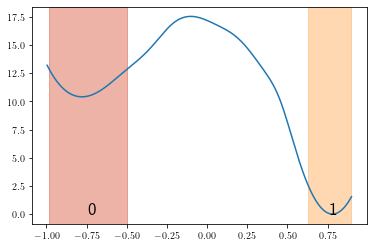

In [62]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
num_samples=500

empirical_centers = cv[cv_list].to_numpy()
KDE = gaussian_kde(empirical_centers,bandwidth)

bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

positions = np.vstack([g.ravel() for g in mesh]).T
fes = -kBT*KDE.logpdf(positions) #.reshape(num_samples,num_samples)
fes -= fes.min()
plt.plot(mesh[0],fes)
#fes,grid,bounds,error = compute_fes(cv[cv_list].values,bandwidth=bandwidth,plot=True,num_samples=500)
#plt.plot(grid,fes)
n_states = len(states_labels['labels'].unique())

for i in range(n_states):
    mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
    Min = cv[mask][cv_list].min().values[0] 
    Max = cv[mask][cv_list].max().values[0] 
    plt.axvspan(Min,Max, alpha=0.45,color=f'fessa{6-i}')
    print(Min,Max,(Max+Min)/2)
    plt.text((Max+Min)/2,0,i,fontsize=18)

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:71: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 101/101 [00:01<00:00, 86.45it/s] 


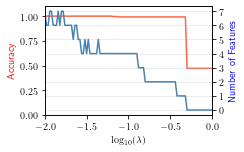

In [37]:
regularizers = np.geomspace(0.01, 1, 101)
select_feat = 'HB_CONTACT' #'sin_|cos_'
sample_obj, features_names, classes_names = prepare_training_dataset(desc, states_labels, 500, regex_filter=select_feat,) 
                                                    #states_subset=states_subset, states_names=state_names)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

classifier.plot();

Accuracy: 99%
State 1:
 HB_CONTACT ARG42-N -- ASN43-N
 HB_CONTACT LYS41-N -- ARG42-N


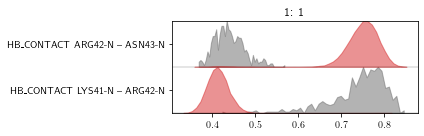

In [38]:
from stateinterpreter.utils.plot import plot_histogram_features
import matplotlib.pyplot as plt 

reg = 10**(-0.5)
classifier.print_selected(reg)

relevant_feat = classifier.feature_summary(reg)
plot_histogram_features(descriptors,states_labels,classes_names,relevant_feat)

### TICA 2

In [63]:
# filter colvar
cv_list = ['DeepTICA 2']
mask = colvar['DeepTICA 1'] > -0.125
cv = colvar[mask].reset_index()
desc = descriptors[mask].reset_index()

# filter HB-descriptors
# Select only contacts which are greater than 0.5 at least once for these states
selected = ((desc.filter(regex='HB_CONTACT')>0.5).sum()>0)
desc = desc[selected.index[selected]]
print(desc.shape)

# bandwitdth
bandwidth = 0.1
std = cv[cv_list].std().values[0]

# identify states
states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, fes_cutoff=kBT)
#fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=bandwidth,plot=True,num_samples=500)

(20110, 747)
DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 12792 configurations.
	Basin 1 -> 5045 configurations.


0
1


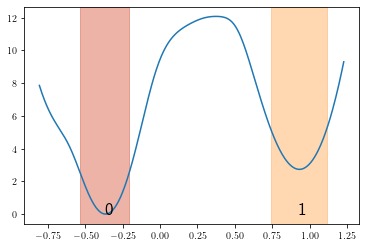

In [64]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
num_samples=500

empirical_centers = cv[cv_list].to_numpy()
KDE = gaussian_kde(empirical_centers,bandwidth)

bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

positions = np.vstack([g.ravel() for g in mesh]).T
fes2 = -kBT*KDE.logpdf(positions) #.reshape(num_samples,num_samples)
fes2 -= fes2.min()
plt.plot(mesh[0],fes2)
#fes,grid,bounds,error = compute_fes(colvar[cv_list].values,bandwidth=bandwidth,plot=True,num_samples=500)
#plt.plot(grid,fes)

n_states = len(states_labels['labels'].unique())

for i in range(n_states):
    print(i)
    mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
    Min = cv[mask][cv_list].min().values[0] 
    Max = cv[mask][cv_list].max().values[0] 
    plt.axvspan(Min,Max, alpha=0.45,color=f'fessa{6-i}')
    plt.text((Max+Min)/2,0,i,fontsize=18)

Optimizing Lasso Estimator: 100%|██████████| 101/101 [00:02<00:00, 40.34it/s]


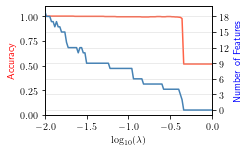

In [52]:
regularizers = np.geomspace(0.01, 1, 101)
select_feat = None #'sin_|cos_'
sample_obj, features_names, classes_names = prepare_training_dataset(desc, states_labels, 1000, regex_filter=select_feat,) 
                                                    #states_subset=states_subset, states_names=state_names)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

classifier.plot();

Accuracy: 99%
State 1:
 HB_CONTACT CYS14-N -- GLY36-O
 HB_CONTACT ALA16-N -- GLY36-O
 HB_CONTACT LYS15-N -- ALA16-N
 HB_CONTACT TYR35-OHs -- CYS38-N


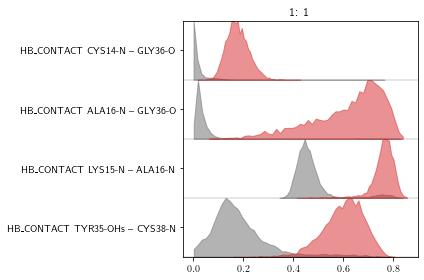

In [53]:
from stateinterpreter.utils.plot import plot_histogram_features
import matplotlib.pyplot as plt 

reg = 10**(-0.4)
classifier.print_selected(reg)
relevant_feat = classifier.feature_summary(reg)
plot_histogram_features(desc,states_labels,classes_names,relevant_feat)

### TICA 3

In [112]:
# filter colvar
cv_list = ['DeepTICA 3']
mask = (colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)
cv = colvar[mask].reset_index()
desc = descriptors[mask].reset_index()

# filter HB-descriptors
# Select only contacts which are greater than 0.5 at least once for these states
selected = ((desc.filter(regex='HB_CONTACT')>0.5).sum()>0)
desc = desc[selected.index[selected]]
print(desc.shape)

# bandwitdth
bandwidth = 0.05
std = cv[cv_list].std().values[0]

# identify states
states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, fes_cutoff=kBT, gradient_descent_iterates=5)
#fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=bandwidth,plot=True,num_samples=500)

(7350, 662)
DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 4 local minima with selected populations:
	Basin 0 -> 797 configurations.
	Basin 1 -> 435 configurations.
	Basin 2 -> 5246 configurations.
	Basin 3 -> 273 configurations.


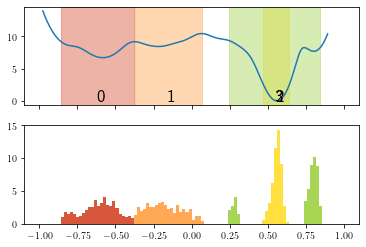

In [123]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
num_samples=500

empirical_centers = cv[cv_list].to_numpy()
KDE = gaussian_kde(empirical_centers,bandwidth)

bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

positions = np.vstack([g.ravel() for g in mesh]).T
fes2 = -kBT*KDE.logpdf(positions) #.reshape(num_samples,num_samples)
fes2 -= fes2.min()

fig, axs = plt.subplots(2,1,sharex=True)
ax = axs[0]
ax.plot(mesh[0],fes2)
#fes,grid,bounds,error = compute_fes(colvar[cv_list].values,bandwidth=bandwidth,plot=True,num_samples=500)
#plt.plot(grid,fes)

n_states = len(states_labels['labels'].unique())

for i in range(n_states):
    ax = axs[0]
    mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
    Min = cv[mask][cv_list].min().values[0] 
    Max = cv[mask][cv_list].max().values[0] 
    ax.axvspan(Min,Max, alpha=0.45,color=f'fessa{6-i}')
    ax.text((Max+Min)/2,0,i,fontsize=18)

for i in range(n_states):
    ax = axs[1]
    mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
    x = cv[mask][cv_list].values
    ax.hist(x,bins=100,color=f'fessa{6-i}',range=[-1,1],density=True)

In [88]:
gradient_descent_iterates = 50

pts = [np.copy(KDE.dataset)[cv[((states_labels['labels']==3) & (cv['DeepTICA 3']<0.5))].index]]
v = np.zeros_like(pts[0])
beta = 0.9 #Default
learning_rate = np.diag(np.diag(KDE.inv_bwidth)**-1)*0.5

for i in range(gradient_descent_iterates): 
    v*= beta
    v += - (1 - beta)*KDE.grad(pts[-1], logpdf=True)
    #pts -= np.dot(v,learning_rate)
    pts.append(pts[-1]-np.dot(v,learning_rate))

In [111]:
import numpy.ma as ma
x = pts[0]
minima = np.asarray([-0.25,-0.5,0.55,0.75])
masked = np.min(np.abs(x-minima),axis=1) < 5*bandwidth
mx = ma.masked_array(pts[0], mask=mask)

mx += - (1 - beta)*KDE.grad(mx, logpdf=True)


[[-0.27814706]
 [-0.283023  ]
 [ 0.30333272]
 [-0.28645741]
 [ 0.30577564]]
[[-0.49185288]
 [-0.51289673]
 [ 0.30333272]
 [-0.52753247]
 [ 0.30577564]]


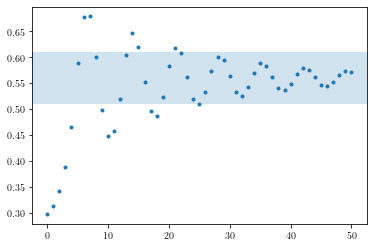

In [89]:
pts_ev = np.array(pts).squeeze()
plt.plot(pts_ev[:,10],'.')
plt.axhspan(0.51,0.61,alpha=0.2)

In [10]:
gradient_descent_iterates = 5

pts = np.copy(KDE.dataset)
v = np.zeros_like(pts)
beta = 0.9 #Default
learning_rate = np.diag(np.diag(KDE.inv_bwidth)**-1)
for _ in range(gradient_descent_iterates): 
    v*= beta
    v += -(1 - beta)*KDE.grad(pts, logpdf=True)
    pts -= np.dot(v,learning_rate)

In [15]:
norms = np.linalg.norm((pts[:,np.newaxis,:] - minima), axis=2)
classes = np.argmin(norms, axis=1)
fes_at_minima = - KDE.logpdf(minima)
ref_fes = np.asarray([fes_at_minima[idx] for idx in classes])
fes_pts = - KDE.logpdf(KDE.dataset)
mask = (fes_pts - ref_fes) < fes_cutoff
df = pd.DataFrame(data=classes, columns=["labels"])
df["selection"] = mask

NameError: name 'minima' is not defined

0
1
2
3


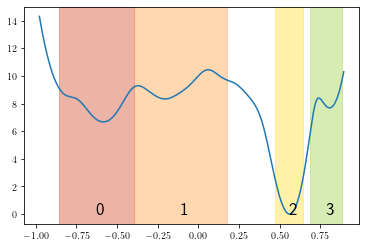

In [79]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
num_samples=500

empirical_centers = cv[cv_list].to_numpy()
KDE = gaussian_kde(empirical_centers,bandwidth)

bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

positions = np.vstack([g.ravel() for g in mesh]).T
fes2 = -kBT*KDE.logpdf(positions) #.reshape(num_samples,num_samples)
fes2 -= fes2.min()
plt.plot(mesh[0],fes2)
#fes,grid,bounds,error = compute_fes(colvar[cv_list].values,bandwidth=bandwidth,plot=True,num_samples=500)
#plt.plot(grid,fes)

n_states = len(states_labels['labels'].unique())

for i in range(n_states):
    print(i)
    mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
    Min = cv[mask][cv_list].min().values[0] 
    Max = cv[mask][cv_list].max().values[0] 
    plt.axvspan(Min,Max, alpha=0.45,color=f'fessa{6-i}')
    plt.text((Max+Min)/2,0,i,fontsize=18)

In [ ]:
# Merge basins 0 and 1
states_labels[states_labels['labels']==1]['labels'] = 0 

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:71: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 101/101 [00:09<00:00, 10.95it/s]


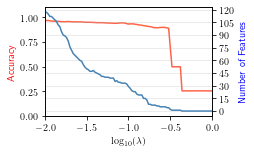

In [67]:
label = states_labels[mask]
regularizers = np.geomspace(0.01, 1, 101)
select_feat = None # 'sin_|cos_'
#states_subset = [0,1]
sample_obj, features_names, classes_names = prepare_training_dataset(desc, states_labels, 500, regex_filter=select_feat)
                                                    #states_subset=states_subset)#, states_names=state_names)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 1000) #, groups=groups)

classifier.plot();

Accuracy: 88%
State 0:
 HB_CONTACT LYS15-N -- GLY37-N
 HB_CONTACT PRO9-O -- LYS41-N
State 1:
 HB_CONTACT ARG39-N -- ALA40-N
State 2:
State 3:
 HB_CONTACT ARG1-N -- THR54-O


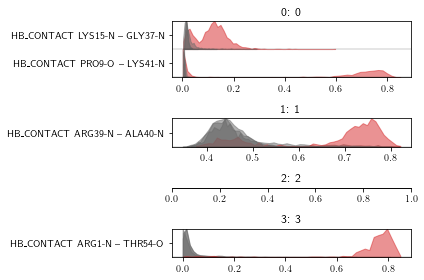

In [70]:
from stateinterpreter.utils.plot import plot_histogram_features
import matplotlib.pyplot as plt 

reg = 10**(-0.52)
classifier.print_selected(reg)
relevant_feat = classifier.feature_summary(reg)
plot_histogram_features(desc,states_labels,classes_names,relevant_feat,height=1)

In [ ]:
# TICA 1
cv = colvar
cv_list = ['DeepTICA 1']
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

# TICA 2
cv_list = ['DeepTICA 2']
cv = colvar[colvar['DeepTICA 1'] > -0.125]
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

# TICA 3
cv_list = ['DeepTICA 3']
cv = colvar[(colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)]
fes,grid,bounds,error = compute_fes(cv[cv_list],bandwidth=0.05,plot=True)

# Semi-automatic classification

Functions

In [4]:
from stateinterpreter.utils.numerical_utils import gaussian_kde

def plot_fes(cv,bandwidth,states_labels=None,logweights=None,kBT=2.5,cv_list=None,states_subset=None,num_samples=100,ax=None,prefix_label=""):
    
    if cv_list is not None:
        cv = cv[cv_list]

    empirical_centers = cv.to_numpy()
    KDE = gaussian_kde(empirical_centers,bandwidth,logweights)

    bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
    mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

    positions = np.vstack([g.ravel() for g in mesh]).T
    fes = -kBT*KDE.logpdf(positions)
    fes -= fes.min()
    if ax is None:
        fig,ax = plt.subplots()
    ax.plot(mesh[0],fes/kBT,color='dimgrey',linewidth=2)
    ax.set_xlabel(cv.columns.values[0])
    ax.set_ylabel('FES [$k_B$T]')
    ax.set_xlim(bounds[0][0],bounds[0][1])
    ax.set_ylim(0,)
    
    if states_labels is not None:
        if states_subset is not None:
            labels = states_subset
        else:
            labels = sorted(states_labels['labels'].unique())
        for i in labels:
            mask = ( states_labels['labels'] == i ) & (states_labels['selection'] == True )
            Min = cv[mask].min().values[0] 
            Max = cv[mask].max().values[0] 
            ax.axvspan(Min,Max, alpha=0.5, color=f'fessa{6-i}')
            ax.text((Max+Min)/2,1,prefix_label+str(i),fontsize=14,ha='center')

def get_best_reg(classifier):
    num = []
    for reg in classifier._reg:
        # get number of features
        selected = classifier._get_selected(reg, feature_mode=False)
        unique_idxs = set()
        for state in selected.values():
            for data in state:
                unique_idxs.add(data[0])
        num.append(len(unique_idxs)) 

    # accuracy
    acc = classifier._crossval

    # criterion
    score = (1-acc)*100+num

    # return reg which minimizes it
    best_reg = np.argmin(score)
    return classifier._reg[best_reg],acc[best_reg],num[best_reg]

In [5]:
def train(cv_list,mask=None,base_state="",merge_states=None,states_subset=None):
    if mask is not None:
        # apply mask
        cv = colvar[mask].reset_index()
        desc = descriptors[mask].reset_index()
        logw = None
        if logweights is not None:
            logw = logweights[mask]
            if type(logw) == pd.DataFrame:
                logw = logw.reset_index()
    else:
        cv = colvar
        desc = descriptors
        logw = logweights

    # filter HB-descriptors
    # Select only contacts which are greater than 0.5 at least once for these states
    if filter_descriptors:
        selected = ((desc.filter(regex='HB_CONTACT')>0.5).sum()>0)
        desc = desc[selected.index[selected]]
        print('Filtering H-bonds:',desc.shape)

    # identify states
    states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, logweights=logw, fes_cutoff=kBT, gradient_descent_iterates=gradient_descent_iterates)
    # merge states if requested 
    if merge_states is not None:
        for pair in merge_states:
            states_labels.loc[states_labels['labels'] == pair[1], 'labels'] = pair[0]
    
    # count states
    if states_subset is None:
        num_states = len(states_labels['labels'].unique())
    else:
        num_states = len(states_subset)
    num_histo = num_states if num_states>2 else 1
    
    # plot setup
    if num_states == 1:
        fig,ax = plt.subplots(figsize=(4.5,3))
    else:
        #fig,axs = plt.subplots(1,2,figsize=(7.5,5))
        fig = plt.figure(figsize=(13.5,3), constrained_layout=True)
        gs = matplotlib.gridspec.GridSpec(num_histo, 3, figure=fig)
        ax1 = fig.add_subplot(gs[:, 0])
        ax2 = fig.add_subplot(gs[:, 1])
        axs_histo = []
        for i in range(num_histo):
            axs_histo.append(fig.add_subplot(gs[i, 2]))
        ax = ax1
        
    plot_fes(cv[cv_list],bandwidth,states_labels,logweights=logw,num_samples=200,states_subset=states_subset,prefix_label=base_state+'.' if len(base_state)>0 else "",ax=ax)
    
    if len(base_state) > 0 :
        ax.set_title( f'State {base_state}' )

    if num_states > 1 :

        # classify
        if states_subset is not None:
            state_names = [f'{base_state}.{i}' for i in states_subset ]
        else:
            state_names = [f'{base_state}.{i}' for i in sorted(states_labels['labels'].unique()) ]
        sample_obj, features_names, classes_names = prepare_training_dataset(desc, states_labels, num_samples, regex_filter=select_feat, states_names=state_names,states_subset=states_subset) 
        classifier = Classifier(sample_obj, features_names, classes_names)
        classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

        # get best reg
        reg,acc,num = get_best_reg(classifier)

        # plot
        ax = ax2
        _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
        ax.axvline(np.log10(reg),linestyle='dotted',color='k')
        ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
        ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

        #print features
        print('Regularization --> log_10 (lambda) = ',np.round(np.log10(reg),3))
        classifier.print_selected(reg)

        relevant_feat = classifier.feature_summary(reg)
        plot_histogram_features(desc, states_labels, classes_names, relevant_feat, axs = axs_histo, height=1)

        #plt.tight_layout()
    if save_folder is not None:
        plt.savefig(save_folder+f'deeptica{cv_list[0][-1]}_state{base_state}_{feat_type}.png', bbox_inches='tight')


Parameters

In [8]:
import matplotlib
from stateinterpreter import identify_metastable_states,prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features

regularizers = np.geomspace(0.01, 1, 51)

logweights = None
num_samples = 5000
bandwidth = 0.1
save_folder = BPTI_data_path+'deeptica/v2-lag100-nodes1024-256-64-3/'
gradient_descent_iterates = 0

In [9]:
# HBONDS
feat_type = 'hbonds'
select_feat = 'HB_CONT'
filter_descriptors = True

In [20]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'
filter_descriptors = False 

In [9]:
# BOTH
feat_type =  'both' 
select_feat =  'sin_|cos_|HB_CONT'
filter_descriptors = False

## TICA 1

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 2294 configurations.
	Basin 1 -> 99096 configurations.


/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:71: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:04<00:00, 10.80it/s]


Regularization --> log_10 (lambda) =  -0.48
Accuracy: 99%
State .1:
 BACKBONE sin_phi ARG42


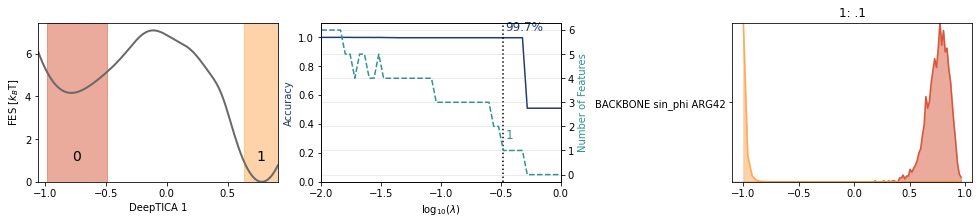

In [21]:
base_state = ""
cv_list = ['DeepTICA 1']
mask = None
train(cv_list,mask,base_state)

## TICA 2

### State 0

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 1 local minima with selected populations:
	Basin 0 -> 2565 configurations.


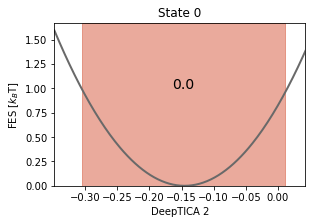

In [22]:
base_state= "0"
cv_list = ['DeepTICA 2']
mask = colvar['DeepTICA 1'] < -0.125
train(cv_list,mask,base_state)

### State 1

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 64048 configurations.
	Basin 1 -> 25286 configurations.


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:04<00:00, 11.10it/s]


Regularization --> log_10 (lambda) =  -0.88
Accuracy: 97%
State 1.1:
 BACKBONE cos_psi LYS15
 BACKBONE sin_phi CYS38
 BACKBONE sin_psi ARG17


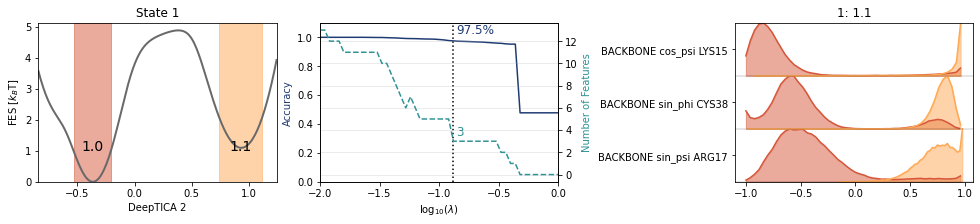

In [23]:
base_state= "1"
cv_list = ['DeepTICA 2']
mask = colvar['DeepTICA 1'] > -0.125
train(cv_list,mask,base_state)

## Tica 3

### State 1.0

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 5 local minima with selected populations:
	Basin 0 -> 1781 configurations.
	Basin 1 -> 6135 configurations.
	Basin 2 -> 4279 configurations.
	Basin 3 -> 48115 configurations.
	Basin 4 -> 2288 configurations.


/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:71: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:17<00:00,  2.88it/s]


Regularization --> log_10 (lambda) =  -0.4
Accuracy: 97%
State 1.0.1:
 BACKBONE cos_psi PRO13
State 1.0.3:
State 1.0.4:
 BACKBONE sin_phi PRO2


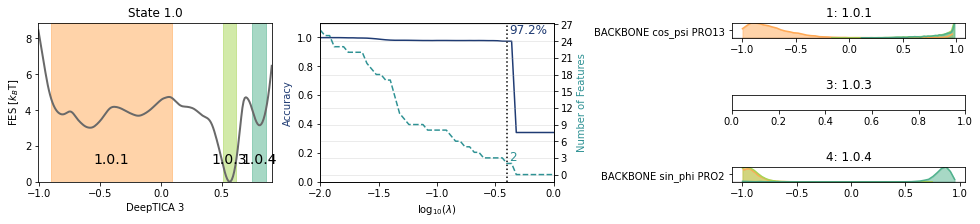

In [24]:
base_state= "1.0"
cv_list = ['DeepTICA 3']
mask = (colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)
#modify parameters
old_bandwidth=bandwidth
bandwidth=0.025
gradient_descent_iterates=5
train(cv_list,mask,base_state,states_subset=[1,3,4],merge_states=[[1,0],[1,2]])

bandwidth = old_bandwidth
gradient_descent_iterates = 0

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 5 local minima with selected populations:
	Basin 0 -> 1781 configurations.
	Basin 1 -> 6135 configurations.
	Basin 2 -> 4279 configurations.
	Basin 3 -> 48115 configurations.
	Basin 4 -> 2288 configurations.


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:04<00:00, 12.25it/s]


Regularization --> log_10 (lambda) =  -0.36
Accuracy: 97%
State 1.0a.3:
 BACKBONE cos_psi PRO13


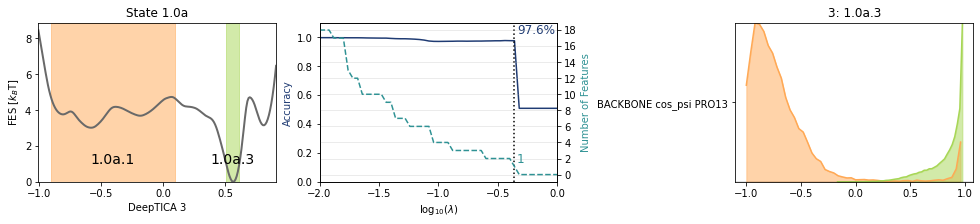

In [26]:
base_state= "1.0a"
cv_list = ['DeepTICA 3']
mask = (colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)
#modify parameters
old_bandwidth=bandwidth
bandwidth=0.025
gradient_descent_iterates=5
train(cv_list,mask,base_state,states_subset=[1,3],merge_states=[[1,0],[1,2]])

bandwidth = old_bandwidth
gradient_descent_iterates = 0

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 5 local minima with selected populations:
	Basin 0 -> 1519 configurations.
	Basin 1 -> 6171 configurations.
	Basin 2 -> 4245 configurations.
	Basin 3 -> 48115 configurations.
	Basin 4 -> 2288 configurations.


/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/ml.py:71: UserWarning: The asked number of samples is higher than the possible unique values. Sampling with replacement
  warnings.warn("The asked number of samples is higher than the possible unique values. Sampling with replacement")
Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:04<00:00, 12.45it/s]


Regularization --> log_10 (lambda) =  -0.52
Accuracy: 99%
State 1.0b.4:
 BACKBONE sin_phi PRO2


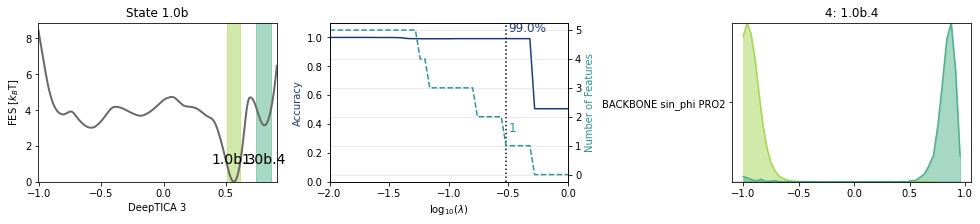

In [27]:
base_state= "1.0b"
cv_list = ['DeepTICA 3']
mask = (colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] < 0.25)
#modify parameters
old_bandwidth=bandwidth
bandwidth=0.025
gradient_descent_iterates=10
train(cv_list,mask,base_state,states_subset=[3,4],merge_states=[[1,0],[1,2]])

bandwidth = old_bandwidth
gradient_descent_iterates = 0

### State 1.1

Filtering H-bonds: (27064, 580)
DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 1 local minima with selected populations:
	Basin 0 -> 26566 configurations.


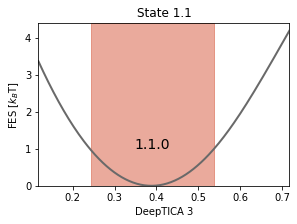

In [19]:
base_state= "1.1"
cv_list = ['DeepTICA 3']
mask = (colvar['DeepTICA 1'] > -0.125) & (colvar['DeepTICA 2'] > 0.25)
train(cv_list,mask,base_state)

# Tree-based classification

## Functions

In [4]:
from stateinterpreter.utils.numerical_utils import gaussian_kde

def plot_fes(cv,bandwidth,states_labels=None,logweights=None,kBT=2.5,cv_list=None,states_subset=None,num_samples=100,ax=None,prefix_label=""):
    
    if cv_list is not None:
        cv = cv[cv_list]

    empirical_centers = cv.to_numpy()
    KDE = gaussian_kde(empirical_centers,bandwidth,logweights)

    bounds = [(x.min(), x.max()) for x in KDE.dataset.T]
    mesh = np.meshgrid(*[np.linspace(b[0], b[1], num_samples) for b in bounds])

    positions = np.vstack([g.ravel() for g in mesh]).T
    fes = -kBT*KDE.logpdf(positions)
    fes -= fes.min()
    if ax is None:
        fig,ax = plt.subplots()
    ax.plot(mesh[0],fes/kBT,color='dimgrey',linewidth=2)
    ax.set_xlabel(cv.columns.values[0])
    ax.set_ylabel('FES [$k_B$T]')
    ax.set_xlim(bounds[0][0],bounds[0][1])
    ax.set_ylim(0,)
    
    if states_labels is not None:
        if states_subset is not None:
            labels = states_subset
        else:
            labels = sorted(states_labels['labels'].unique())
        for i,label in enumerate(labels):
            mask = ( states_labels['labels'] == label ) & (states_labels['selection'] == True )
            Min = cv[mask].min().values[0] 
            Max = cv[mask].max().values[0] 
            ax.axvspan(Min,Max, alpha=0.5, color=f'fessa{6-i}')
            ax.text((Max+Min)/2,1,prefix_label+str(i),fontsize=14,ha='center')

def get_best_reg(classifier):
    # accuracy
    acc = classifier.get_accuracy()
    # number of features
    num = classifier.get_num_features()
    
    # criterion
    score = (1-acc)*100+num

    # return reg which minimizes it
    best_reg = np.argmin(score)
    return classifier._reg[best_reg],acc[best_reg],num[best_reg]

## Build tree

In [5]:
from stateinterpreter.utils.numerical_utils import gaussian_kde
import scipy.optimize as opt
import networkx as nx 
from copy import deepcopy

def find_fes_fixed_points(centers, bandwidth, init_points, tol=1e-5, return_kde = False):
    #Ok only for 1d data. Not checking for saddle points, not checking for dimentions
    kde = gaussian_kde(centers, bandwidth=bandwidth)
    dKDE = lambda x: -kde.grad(x, logpdf=True)
    roots, converged, _ = opt.newton(dKDE,init_points, tol=tol*1e-2, full_output=True, disp=False)
    b = roots[converged]
    b.sort()
    d = np.append(True, np.diff(b))
    roots = b[d>tol]
    if not return_kde:
        return roots[:, np.newaxis]
    else:
        return roots[:, np.newaxis], kde

def get_state_bounds(fixed_points, kde, bounds):
    num_fixed_points = fixed_points.shape[0]
    if num_fixed_points == 1:
        maxima = np.array([[]])
    else:
        diff_signs = np.ones(num_fixed_points -1 )
        diff_signs[1::2] *= -1
        diffs = np.diff(-kde.logpdf(fixed_points), axis=0)
        assert(np.allclose(diff_signs, np.sign(diffs)))
        maxima = fixed_points[1::2]
    state_bounds = []
    maxima = np.insert(maxima, 0, [bounds[0]])
    maxima = np.append(maxima, [bounds[1]])
    for i in range(len(maxima) -1):
        inf = maxima[i]
        sup = maxima[i + 1]
        data = dict()
        data['bounds'] = [inf, sup]
        data['enclosed_minima'] = fixed_points[i*2]
        data['f_min'] = -kde.logpdf(data['enclosed_minima'])
        if i == 0:
            data['f_infbdry'] = None
        else: 
            data['f_infbdry'] = -kde.logpdf(np.array(inf))
        if i == len(maxima) - 2: 
            data['f_supbdry'] = None 
        else:
            data['f_supbdry'] = - kde.logpdf(np.array(sup))
        state_bounds.append(data)
    return state_bounds

def fuse_bounds(state_bounds, tol = 0.5):
    state_bounds = deepcopy(state_bounds)
    for idx, d in enumerate(state_bounds):
        if d['f_infbdry'] == None:
            if d['f_supbdry'] == None:
                #Already single state
                pass
            else:
                d_sup = d['f_supbdry'] - d['f_min']
                if d_sup < tol:
                    return fuse_bounds(fuse_above(state_bounds, idx), tol)
        elif d['f_supbdry'] == None:
            if d['f_infbdry'] == None:
                #Already single state
                pass
            else:
                d_inf = d['f_infbdry'] - d['f_min']
                if d_inf < tol:
                    return fuse_bounds(fuse_below(state_bounds, idx), tol)
        else:
            d_sup = d['f_supbdry'] - d['f_min']
            d_inf = d['f_infbdry'] - d['f_min']
            if (d_sup < tol) and (d_inf >= tol):
                return fuse_bounds(fuse_above(state_bounds, idx), tol)
            if (d_sup >= tol) and (d_inf < tol):
                return fuse_bounds(fuse_below(state_bounds, idx), tol)
            if (d_sup < tol) and (d_inf < tol):
                if d_inf < d_sup:
                    return fuse_bounds(fuse_below(state_bounds, idx), tol)
                else:
                    return fuse_bounds(fuse_above(state_bounds, idx), tol)
            else:
                pass
    return state_bounds
    
def fuse_below(state_bounds, idx):
    assert idx > 0
    state_bounds[idx - 1]['bounds'][1] = state_bounds[idx]['bounds'][1]
    state_bounds[idx -1]['f_supbdry'] = state_bounds[idx]['f_supbdry']
    if state_bounds[idx -1]['f_min'] >= state_bounds[idx]['f_min']:
        state_bounds[idx -1]['f_min'] = state_bounds[idx]['f_min']
        state_bounds[idx -1]['enclosed_minima'] = state_bounds[idx]['enclosed_minima']
    state_bounds.pop(idx)
    return state_bounds

def fuse_above(state_bounds, idx):
    assert idx < len(state_bounds) - 1
    state_bounds[idx + 1]['bounds'][0] = state_bounds[idx]['bounds'][0]
    state_bounds[idx + 1]['f_infbdry'] = state_bounds[idx]['f_infbdry']
    if state_bounds[idx + 1]['f_min'] >= state_bounds[idx]['f_min']:
        state_bounds[idx + 1]['f_min'] = state_bounds[idx]['f_min']
        state_bounds[idx + 1]['enclosed_minima'] = state_bounds[idx]['enclosed_minima']
    state_bounds.pop(idx)
    return state_bounds

def branch_tica(centers, bandwidth, fusing_tolerance=1):
    inf, sup = np.min(centers), np.max(centers)
    padding = 1.1
    init_points = np.arange(inf*padding, sup*padding, bandwidth)[:, np.newaxis]
    fixed_points, kde = find_fes_fixed_points(centers[:, np.newaxis], bandwidth, init_points, return_kde = True)
    state_bounds = get_state_bounds(fixed_points, kde, [inf, sup])
    state_bounds = fuse_bounds(state_bounds, tol = fusing_tolerance)
    for d in state_bounds:
        inf = d['bounds'][0]
        sup = d['bounds'][1]
        d['mask'] = np.logical_and(centers > inf, centers < sup)
    return state_bounds

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = np.random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = sorted(list(G.neighbors(root)))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos
    
def populate_tree(T, parent_node, ticas, bandwidth, fusing_tolerance):
    parent_mask = T.nodes[parent_node]['mask']
    if ticas.shape[1] >= 1:
        tica = ticas[parent_mask,0]
        next_tica = ticas[:, 1:]
    elif ticas.shape[1] == 0:
        return
    leafs = branch_tica(tica, bandwidth, fusing_tolerance=fusing_tolerance)
    for leaf_id, leaf in enumerate(leafs):
        leaf_mask = np.zeros_like(parent_mask)
        nonzero_idxs = parent_mask.nonzero()[0]
        leaf_mask[nonzero_idxs] = leaf['mask']
        leaf_name = parent_node + f".{leaf_id + 1}"
        T.add_node(leaf_name, mask = leaf_mask)
        T.add_edge(parent_node, leaf_name)
        populate_tree(T, leaf_name, next_tica, bandwidth, fusing_tolerance)

def state_tree(ticas, bandwidth, fusing_tolerance=1):
    T = nx.DiGraph()
    T.add_node('0', mask=np.ones(ticas.shape[0], dtype=bool))
    populate_tree(T, '0', ticas, bandwidth, fusing_tolerance)
    relabel_map = dict()
    for node in T.nodes:
        if node == '0':
            relabel_map[node] = 'MD'
        else:
            relabel_map[node] = node[2:]
    T = nx.relabel_nodes(T,relabel_map, copy=False)
    unchanged = False
    while not unchanged:
        unchanged = True
        trimming_list = []
        for node in T.nodes:
            if T.out_degree(node) == 0:
                parent_node = list(T.in_edges(node))[0][0]
                if T.out_degree(parent_node) == 1:
                    unchanged = False
                    trimming_list.append(node)
        T.remove_nodes_from(trimming_list)
    return T

In [6]:
bandwidth = 0.1
ticas = colvar.filter(regex='DeepTICA').values #TODO add filter
T = state_tree(ticas, bandwidth)

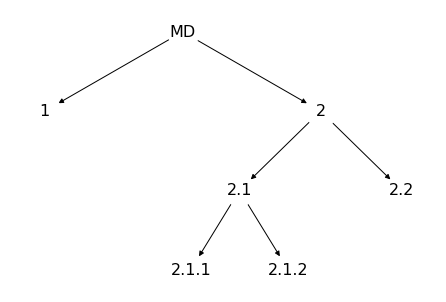

In [7]:
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}

nx.draw(T, pos, **options)

In [8]:
import pandas as pd
def generate_state_labels(T, root='Equilibrium'):
    labels_list = []
    _inspect_childrens(root,T, labels_list)
    return labels_list
def _inspect_childrens(node, T, labels_list):
    if len(T.out_edges(node)) == 0:
        return labels_list
    else:
        childrens = [i[1] for i in T.out_edges(node)]
        masks = [T.nodes[child]['mask'] for child in childrens]
        mask = np.logical_or.reduce(masks)
        classes = np.full(mask.shape, 'undefined')
        for id, m in enumerate(masks):
            classes[m] = childrens[id]
        df = pd.DataFrame(data=classes, columns=["labels"])
        df["selection"] = mask
        labels_list.append(df.copy())
        for child in childrens:
            labels_list = _inspect_childrens(child, T, labels_list)

In [13]:
## apply threshold to points selection based on FES

def get_minima(fixed_points,kde):
    num_fixed_points = fixed_points.shape[0]
    if num_fixed_points == 1:
        minima = [fixed_points[0]]
    else:
        diff_signs = np.ones(num_fixed_points -1 )
        diff_signs[1::2] *= -1
        diffs = np.diff(-kde.logpdf(fixed_points), axis=0)
        assert(np.allclose(diff_signs, np.sign(diffs)))
        minima = fixed_points[0::2]

    return minima

def apply_cutoff_selection(centers, bandwidth, fes_cutoff=1):
    # find minima
    inf, sup = np.min(centers), np.max(centers)
    padding = 1.1
    init_points = np.arange(inf*padding, sup*padding, bandwidth)[:, np.newaxis]
    fixed_points, kde = find_fes_fixed_points(centers[:, np.newaxis], bandwidth, init_points, return_kde = True)
    minima = get_minima(fixed_points, kde)

    # apply mask selection
    norms = np.linalg.norm((centers[:,np.newaxis,:] - minima), axis=2)
    classes = np.argmin(norms, axis=1)
    fes_at_minima =  - kde.logpdf(minima)
    ref_fes = np.asarray([fes_at_minima[idx] for idx in classes])
    fes_pts = - kde.logpdf(kde.dataset)
    mask = (fes_pts - ref_fes) < fes_cutoff

    return mask

apply_cutoff_selection(colvar['DeepTICA 1'], bandwidth)

/tmp/ipykernel_1522769/1020896860.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  fixed_points, kde = find_fes_fixed_points(centers[:, np.newaxis], bandwidth, init_points, return_kde = True)
/tmp/ipykernel_1522769/1020896860.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  norms = np.linalg.norm((centers[:,np.newaxis] - minima), axis=2)


ValueError: operands could not be broadcast together with shapes (103125,1) (2,1) 

## Train

In [16]:
def train(cv_list,mask=None,merge_states=None,states_subset=None):
    if mask is not None:
        # apply mask
        cv = colvar[mask].reset_index()
        desc = descriptors[mask].reset_index()
        logw = None
        if logweights is not None:
            logw = logweights[mask]
            if type(logw) == pd.DataFrame:
                logw = logw.reset_index()
    else:
        cv = colvar
        desc = descriptors
        logw = logweights

    # filter HB-descriptors
    # Select only contacts which are greater than 0.5 at least once for these states
    if filter_descriptors:
        selected = ((desc.filter(regex='HB_CONTACT')>0.5).sum()>0)
        desc = desc[selected.index[selected]]
        print('Filtering H-bonds:',desc.shape)

    ### identify states
    ## states_labels = identify_metastable_states(cv, cv_list, kBT, bandwidth, logweights=logw, fes_cutoff=kBT, gradient_descent_iterates=gradient_descent_iterates)
    # merge states if requested 
    if merge_states is not None:
        for pair in merge_states:
            states_labels.loc[states_labels['labels'] == pair[1], 'labels'] = pair[0]
    
    # count states
    if states_subset is None:
        num_states = len(states_labels['labels'].unique())
    else:
        num_states = len(states_subset)
    num_histo = num_states if num_states>2 else 1
    
    # plot setup
    if num_states == 1:
        fig,ax = plt.subplots(figsize=(4.5,3))
    else:
        #fig,axs = plt.subplots(1,2,figsize=(7.5,5))
        fig = plt.figure(figsize=(13.5,3), constrained_layout=True)
        gs = matplotlib.gridspec.GridSpec(num_histo, 3, figure=fig)
        ax1 = fig.add_subplot(gs[:, 0])
        ax2 = fig.add_subplot(gs[:, 1])
        axs_histo = []
        for i in range(num_histo):
            axs_histo.append(fig.add_subplot(gs[i, 2]))
        ax = ax1
        
    plot_fes(cv[cv_list],bandwidth,states_labels,logweights=logw,num_samples=200,states_subset=states_subset,ax=ax) ## prefix_label=base_state+'.' if len(base_state)>0 else ""
    
    ##if len(base_state) > 0 :
    ##    ax.set_title( f'State {base_state}' )

    if num_states > 1 :

        # classify
        ##if states_subset is not None:
        ##    state_names = [f'{base_state}.{i}' for i in states_subset ]
        ##else:
        ##    state_names = [f'{base_state}.{i}' for i in sorted(states_labels['labels'].unique()) ]
        state_names = None
        sample_obj, features_names, classes_names = prepare_training_dataset(desc, states_labels, num_samples, regex_filter=select_feat, states_names=state_names,states_subset=states_subset) 
        print(classes_names)
        classifier = Classifier(sample_obj, features_names, classes_names)
        classifier.compute(regularizers, max_iter= 10000) #, groups=groups)

        # get best reg
        reg,acc,num = get_best_reg(classifier)

        # plot
        ax = ax2
        _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
        ax.axvline(np.log10(reg),linestyle='dotted',color='k')
        ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
        ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

        #print features
        print('Regularization --> log_10 (lambda) = ',np.round(np.log10(reg),3))
        classifier.print_selected(reg)

        relevant_feat = classifier.feature_summary(reg)
        plot_histogram_features(desc, states_labels, classes_names, relevant_feat, axs = axs_histo, height=1)

        #plt.tight_layout()
    if save_folder is not None:
        plt.savefig(save_folder+f'deeptica{cv_list[0][-1]}_state{base_state}_{feat_type}.png', bbox_inches='tight')


In [10]:
import matplotlib
from stateinterpreter import identify_metastable_states,prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features

regularizers = np.geomspace(0.01, 1, 51)

logweights = None
num_samples = 1000
#bandwidth = 0.05
save_folder = None #BPTI_data_path+'deeptica/v2-lag100-nodes1024-256-64-3/'
#gradient_descent_iterates = 0

In [14]:
# HBONDS
feat_type = 'hbonds'
select_feat = 'HB_CONT'
filter_descriptors = True

In [12]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'
filter_descriptors = False 

['DeepTICA 1'] ['2' '1']
Filtering H-bonds: (103123, 927)
{0: '1', 1: '2'}


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 337.25it/s]

Regularization --> log_10 (lambda) =  -0.96
Accuracy: 98%
State 2:
 HB_CONTACT LYS41-N -- ARG42-N
 HB_CONTACT LEU6-N -- GLU7-N
 HB_CONTACT ARG42-N -- ASN43-N


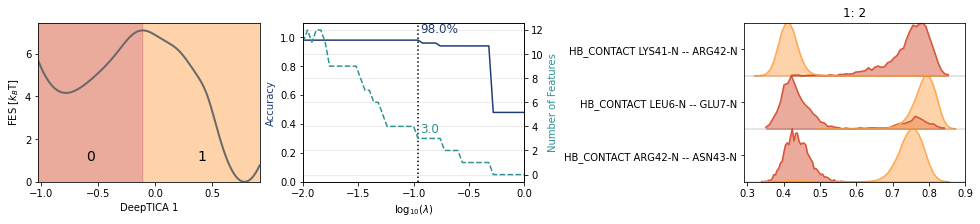

['DeepTICA 2'] ['2.2' '2.1']
Filtering H-bonds: (100541, 871)
{0: '2.1', 1: '2.2'}


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 350.38it/s]

Regularization --> log_10 (lambda) =  -0.36
Accuracy: 98%
State 2.2:
 HB_CONTACT CYS14-N -- GLY36-O


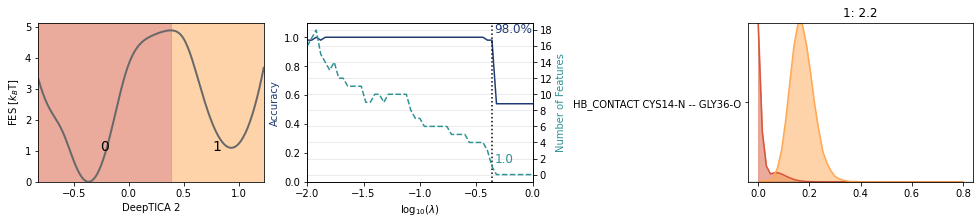

['DeepTICA 3'] ['2.1.2' '2.1.1']
Filtering H-bonds: (73703, 852)
{0: '2.1.1', 1: '2.1.2'}


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 361.76it/s]

Regularization --> log_10 (lambda) =  -0.72
Accuracy: 100%
State 2.1.2:
 HB_CONTACT PRO13-N -- CYS14-N
 HB_CONTACT TYR10-O -- ASN44-ND2s
 HB_CONTACT CYS38-N -- ARG39-N


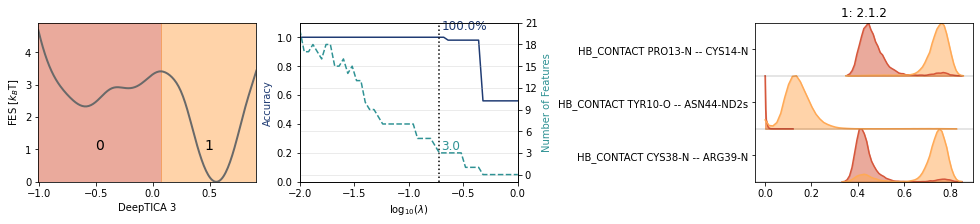

In [17]:
labels_list = generate_state_labels(T,root='MD')

for labels in labels_list:
    mask = labels['labels'] != 'undefined'
    states_labels = labels[mask].reset_index()

    cv_level = states_labels['labels'][0].count('.')+1
    cv_list = [f'DeepTICA {cv_level}']
    print(cv_list, states_labels['labels'].unique())

    train(cv_list,mask)
    plt.show()